In [1]:
%load_ext autoreload
%autoreload 2

In [175]:
from pathlib import Path
from nptdms import TdmsFile
import matplotlib.pyplot as plt
import numpy as np
import cv2
from barcodes import extract_barcodes_from_times

In [126]:
tdms_path = Path('/Volumes/neuropixel_archive/Data/chronic/CNPIX7-Giuseppe/CameraSynctest/2-3-2020_CameraSyncTest.tdms')
mp4_path = Path('/Volumes/neuropixel_archive/Data/chronic/CNPIX7-Giuseppe/CameraSynctest/e3v8125-20210203T172711-172902.mp4')
lfp_path = Path('/Volumes/neuropixel_archive/Data/chronic/CNPIX7-Giuseppe/CameraSyncTest/2-2-2020_CameraSyncTest_g0/2-2-2020_CameraSyncTest_g0_imec0/2-2-2020_CameraSyncTest_g0_t0.imec0.lf.bin')

In [21]:
def binarize(x, threshold):
    return np.where(x > threshold, 1, 0)

In [25]:
def get_rising_edges(x):
    """Assumes x is binarized"""
    return np.squeeze(np.where(np.diff(x, prepend=np.nan) == 1))

In [26]:
def get_falling_edges(x):
    """Assumes x is binarized"""
    return np.squeeze(np.where(np.diff(x, prepend=np.nan) == -1))

# Handle NI

In [17]:
tdms_file = TdmsFile.read(tdms_path)

In [18]:
for group in tdms_file.groups():
    group_name = group.name
    print("Group: ", group_name)
    for channel in group.channels():
        channel_name = channel.name
        print("\t", "Channel: ", channel_name)

Group:  Default
Group:  Recording 2
	 Channel:  camera_in
	 Channel:  barcode_in


In [19]:
ni_camera_in = tdms_file['Recording 2']['camera_in']
ni_barcode_in = tdms_file['Recording 2']['barcode_in']

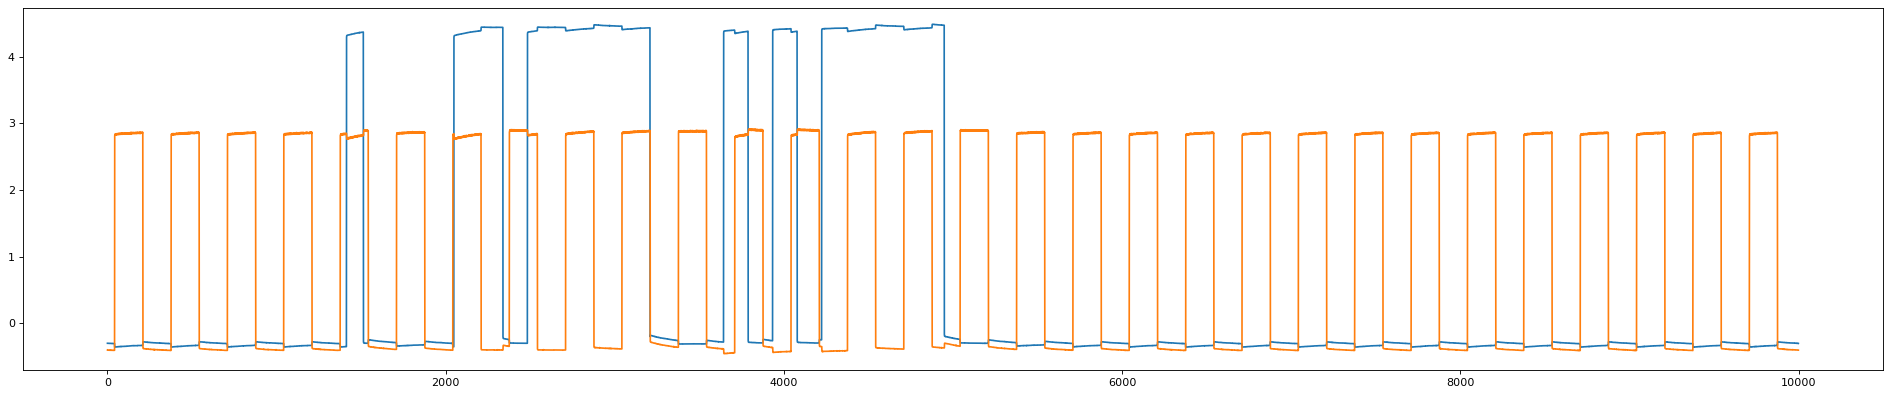

In [149]:
plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ni_barcode_in[160000:170000])
plt.plot(ni_camera_in[160000:170000])

In [22]:
ni_barcode_bin = binarize(ni_barcode_in.data, 4)

In [23]:
ni_camera_bin = binarize(ni_camera_in.data, 2)

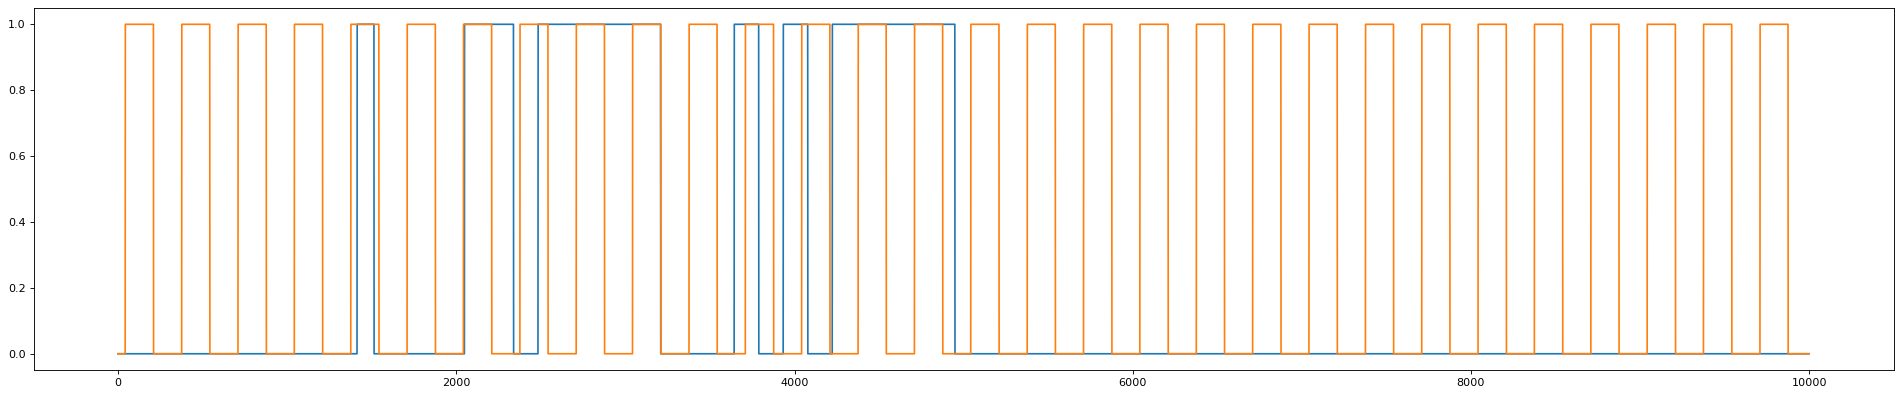

In [148]:
plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ni_barcode_bin[160000:170000])
plt.plot(ni_camera_bin[160000:170000])

In [194]:
ni_barcode_rising_edges = ni_barcode_in.time_track()[get_rising_edges(ni_barcode_bin)]
ni_barcode_falling_edges = ni_barcode_in.time_track()[get_falling_edges(ni_barcode_bin)]

In [200]:
ni_barcode_start_times, ni_barcodes = extract_barcodes_from_times(ni_barcode_rising_edges, ni_barcode_falling_edges, bar_duration=0.029)

In [201]:
frame_rising_edges = ni_camera_in.time_track()[get_rising_edges(ni_camera_bin)]
frame_falling_edges = ni_camera_in.time_track()[get_falling_edges(ni_camera_bin)]

In [197]:
def get_frame_times(rising_edges, falling_edges, threshold):
    frame_start_edges = list()
    for pulse_on in rising_edges:
        pulse_off = falling_edges[falling_edges > pulse_on].min()
        pulse_width = pulse_off - pulse_on
        if pulse_width > threshold:
            frame_start_edges.append(pulse_on)
        
    return np.asarray(frame_start_edges)

In [198]:
ni_frame_times = get_frame_times(frame_rising_edges, frame_falling_edges, 33/1000)

# Handle video

In [7]:
cap = cv2.VideoCapture(str(mp4_path))

In [15]:
int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

1680

In [76]:
fps = cap.get(cv2.CAP_PROP_FPS)

In [287]:
#frame_number = 1679
#cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # 0 based indexing
cap.set(cv2.CAP_PROP_POS_MSEC, 101)
print(cap.get(cv2.CAP_PROP_POS_MSEC))
ret, frame = cap.read()
print(cap.get(cv2.CAP_PROP_POS_MSEC))

0.0101
133.33399999999997


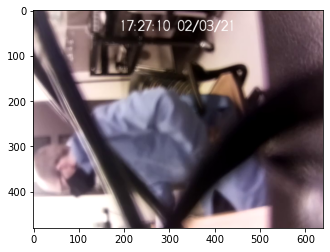

In [288]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Handle SGLX

In [121]:
from readSGLX import readMeta, SampRate, makeMemMapRaw, ExtractDigital

In [167]:
def sglx_load_sync(bin_path):
    """Load the sync channel from the specified binary file.
    The SpikeGLX metadata file must be present in the same directory as the binary file."""
    meta = readMeta(bin_path)
    rawData = makeMemMapRaw(bin_path, meta)
    fs = SampRate(meta)

    # Read the entire file
    firstSamp = 0
    lastSamp = rawData.shape[1] - 1
    
    # Get timestamps of each sample
    time = np.arange(firstSamp, lastSamp + 1)
    time = time / fs  # timestamps in seconds from start of file

    # Which digital word to read.
    # For imec, there is only 1 digital word, dw = 0.
    # For NI, digital lines 0-15 are in word 0, lines 16-31 are in word 1, etc.
    dw = 0
    # Which lines within the digital word, zero-based
    # Note that the SYNC line for PXI 3B is stored in line 6.
    dLineList = [6]
    sync = np.squeeze(ExtractDigital(rawData, firstSamp, lastSamp, dw, dLineList, meta))
    
    return sync, time

In [168]:
sglx_sync, sglx_times = sglx_load_sync(lfp_path)

nChan: 385, nFileSamp: 227049


In [173]:
sglx_rising_edges = sglx_times[get_rising_edges(sglx_barcode_in)]
sglx_falling_edges = sglx_times[get_falling_edges(sglx_barcode_in)]

In [202]:
sglx_barcode_start_times, sglx_barcodes = extract_barcodes_from_times(sglx_rising_edges, sglx_falling_edges, bar_duration=0.029)

# Use barcodes to align streams

In [212]:
from difflib import SequenceMatcher
from sklearn.linear_model import LinearRegression

In [207]:
print(sglx_barcode_start_times)
print(ni_barcode_start_times)

[42.27211363 73.22939685]
[ 32.2828  63.2396  94.1966 125.1536]


In [208]:
print("SpikeGLX barcodes:\n", sglx_barcodes)
print("NI barcodes:\n", ni_barcodes)

SpikeGLX barcodes:
 [356429.0, 356427.0]
NI barcodes:
 [356431.0, 356429.0, 356427.0, 356425.0]


In [211]:
# Find the longest sequence of barcodes recorded by both systems
s = SequenceMatcher(None, sglx_barcodes, ni_barcodes)
match = s.find_longest_match(alo=0, ahi=len(sglx_barcodes), blo=0, bhi=len(ni_barcodes))
shared_barcodes = sglx_barcodes[match.a : match.size]
print("Longest barcode sequence common to both systems:\n", shared_barcodes)

Longest barcode sequence common to both systems:
 [356429.0, 356427.0]


In [223]:
# Using the barcodes shared by both systems, fit the NI barcode times to the SGLX barcode times
y = sglx_barcode_start_times[match.a : match.a + match.size]
x = ni_barcode_start_times[match.b : match.b + match.size].reshape((-1, 1))
model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)

In [224]:
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('drift rate in msec/hr:', (model.coef_[0] - 1)*60*60*1000)

coefficient of determination: 1.0
intercept: -20.968064929790543
drift rate in msec/hr: 32.9355561767386


In [250]:
def visualize_mapping(sglx_rising_edges, ni_rising_edges, model, nPulsesToPlot=20):
    '''Visualize remapped NI sync pulse times in SGLX time space, to verify correctness.
    Black lines = Pulse times measured by SGLX.
    Red lines = Pulse times measured by NI and remapped to SGLX time space. '''
    remapped_ni_times = model.predict(ni_rising_edges.reshape((-1, 1)))
    
    plt.figure(num=None, figsize=(30, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.vlines(sglx_rising_edges[:nPulsesToPlot], 0, 1, colors='black')
    plt.vlines(remapped_ni_times[:nPulsesToPlot], 0, 1, linestyle='dotted', colors='red')

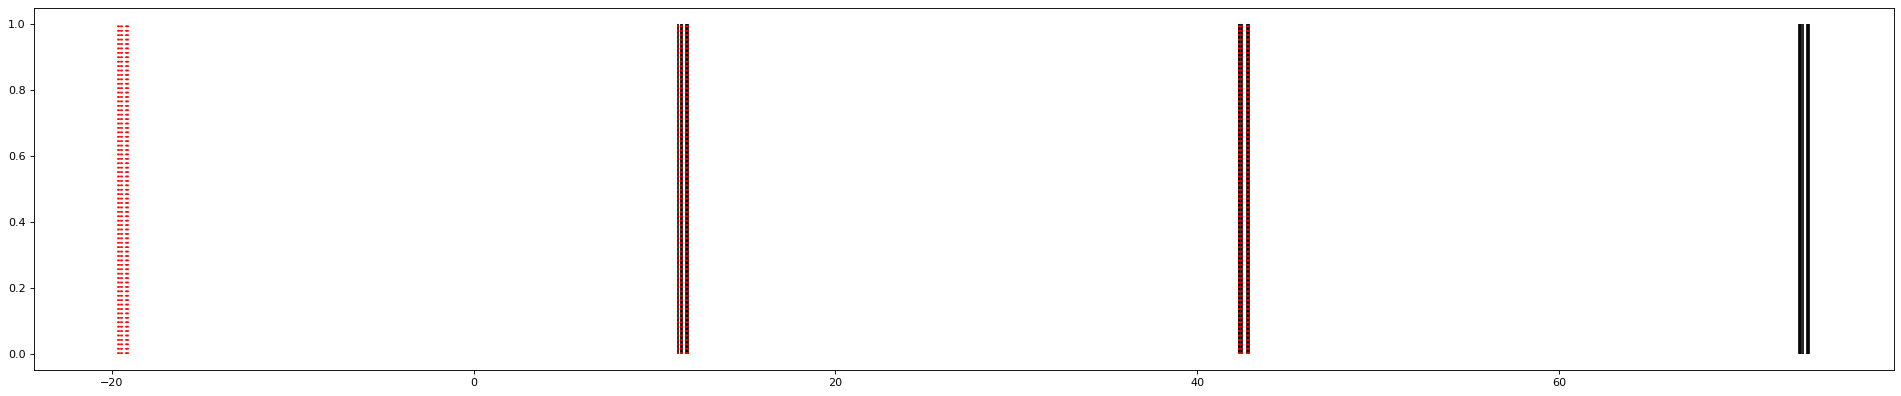

In [251]:
visualize_mapping(sglx_rising_edges, ni_barcode_rising_edges, model)

In [255]:
remapped_frame_times = model.predict(ni_frame_times.reshape((-1, 1))) # frame times in SGLX space

# Get closest frame

In [304]:
sglx_toi = 60

In [305]:
frame_number = (np.abs(remapped_frame_times - sglx_toi)).argmin()
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()

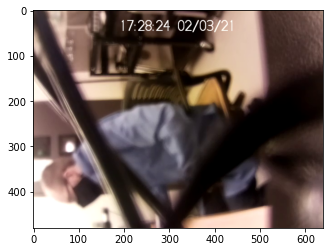

In [306]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))